# Camera Image Capture

## Setup python dependencies

```bash
# to install picamera2
$ sudo apt update
$ sudo apt upgrade
$ sudo apt install -y python3-picamera2

# create venv using system packages
$ python -m venv --system-site-packages .venv

# activate venv and install additional dependencies
$ source .venv/bin/activate
$ pip install torch torchvision torchaudio opencv-python matplotlib jupyter
```

In [1]:
import cv2
import IPython.display as ipython
import ipywidgets as widgets


In [2]:
import threading
from time import sleep
from typing import Tuple

from libcamera import controls
from picamera2 import Picamera2


class VideoCapture(threading.Thread):
    def __init__(self, cam):
        super().__init__()
        self.cam = cam
        self.frame = None
        self.capture = False
    
    def run(self):
        try:
            while self.capture:
                self.frame = self.cam.capture_array()
        finally:
            pass

    def start(self):
        self.capture = True

        # There are three autoFocus modes: Manual, Auto, and Continuous
        self.cam.set_controls({"AfMode": controls.AfModeEnum.Continuous})
        self.cam.start()
        sleep(1)  # delay for starting the cam
        super().start()
    
    def stop(self):
        self.capture = False
        self.join()
        self.cam.stop()


class Camera():
    def __init__(self, resolution: Tuple = (320, 320)):
        self.cam = Picamera2()
        # Picamera2.create_preview_configuration will generate a configuration suitable for displaying camera preview images on the display, or prior to capturing a still image
        # Picamera2.create_still_configuration will generate a configuration suitable for capturing a high-resolution still image
        # Picamera2.create_video_configuration will generate a configuration suitable for recording video files
        self.cam.configure(self.cam.create_preview_configuration(main={"format": 'RGB888', "size": resolution}))
        self.video_capture = None
    
    def start(self):
        self.stop()
        self.video_capture = VideoCapture(self.cam)
        self.video_capture.start()

    def stop(self):
        if self.video_capture is not None:
            self.video_capture.stop()
            self.video_capture = None

    def get_frame(self):
        if self.video_capture is not None:
            return self.video_capture.frame
        else:
            return None

In [3]:
cam = Camera()

[0:11:13.663956001] [1649]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[0:11:13.711003287] [1776]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:11:13.712984403] [1776]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media4 and ISP device /dev/media0
[0:11:13.713040684] [1776]  INFO RPI pipeline_base.cpp:1125 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:11:13.722877670] [1649]  INFO Camera camera.cpp:1191 configuring streams: (0) 320x320-RGB888 (1) 1536x864-SBGGR10_CSI2P
[0:11:13.723328581] [1776]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10 - Selected unicam format: 1536x864-pBAA


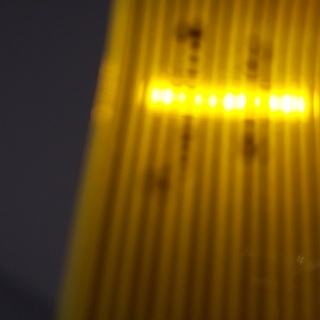

None

Button(button_style='danger', description=' Start Camera', icon='play', style=ButtonStyle())

Button(description=' Capture', disabled=True, style=ButtonStyle())

Button(description='Save', disabled=True, style=ButtonStyle())

In [16]:
from collections import deque
from time import time

display_handle = ipython.display(None, display_id=True)
captured_frame_display_handle = ipython.display(None, display_id=True)

start_btn = widgets.Button(description=" Start Camera", button_style="danger", icon="play")
capture_btn = widgets.Button(description=" Capture", disabled=True)
save_btn = widgets.Button(description="Save", disabled=True)

is_started = False
queue = deque()
frame = None
captured_frame = None

def start_cam():
    global is_started
    global frame
    try:
        cam.start()
        while is_started:
            frame = cam.get_frame()
            if frame is not None:
                _, img = cv2.imencode('.jpeg', frame)
                display_handle.update(ipython.Image(data=img.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        cam.stop()

def on_capture(b):
    # get frame into captured_frame and display
    global captured_frame
    
    captured_frame = frame
    if captured_frame is not None:
        save_btn.disabled = False
        _, img = cv2.imencode('.jpeg', captured_frame)
        captured_frame_display_handle.update(ipython.Image(data=img.tobytes()))

def on_save(b):
    # save captured_frame into a file w/ the timestamp as the name
    global captured_frame
    
    if captured_frame is not None:
        cv2.imwrite(f"{int(time())}.jpg", captured_frame)
        b.disabled = True
        captured_frame = None
        captured_frame_display_handle.update(None)

def on_start(b):
    global is_started
    
    if is_started:
        is_started = False
        capture_btn.disabled = True
        b.description = " Start Camera"
        b.icon = "play"
        if len(queue) > 0:
            thread = queue.popleft()
            thread.join()
    else:
        is_started = True
        capture_btn.disabled = False
        b.description = " Stop Camera"
        b.icon = "stop"
        
        thread = threading.Thread(target=start_cam)
        thread.start()
        queue.append(thread)

start_btn.on_click(on_start)
capture_btn.on_click(on_capture)
save_btn.on_click(on_save)
display(start_btn, capture_btn, save_btn)